In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers

     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     ------------------ --------------------- 20.5/43.7 kB ? eta -:--:--
     ------------------ --------------------- 20.5/43.7 kB ? eta -:--:--
     ------------------ --------------------- 20.5/43.7 kB ? eta -:--:--
     ------------------ --------------------- 20.5/43.7 kB ? eta -:--:--
     -------------------------- ----------- 30.7/43.7 kB 108.9 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/43.7 kB 108.9 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/43.7 kB 108.9 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/43.7 kB 108.9 kB/s eta 0:00:01
     -----------------------

In [2]:
pip install torch


   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/199.4 MB 435.7 kB/s eta 0:07:38
   ---------------------------------------- 0.0/199.4 MB 435.7 kB/s eta 0:07:38
   ---------------------------------------- 0.0/199.4 MB 435.7 kB/s eta 0:07:38
   ---------------------------------------- 0.0/199.4 MB 435.7 kB/s eta 0:07:38
   ---------------------------------------- 0.1/199.4 MB 286.7 kB/s eta 0:11:36
   ---------------------------------------- 0.1/199.4 MB 286.7 kB/s eta 0:11:36
   --------------------

In [1]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import numpy as np

import warnings

# Mengabaikan semua peringatan
warnings.filterwarnings("ignore")

In [3]:
import torch

torch.cuda.is_available()

False

In [8]:
import pandas as pd

df = pd.read_csv('C:/Users/bayu puspito aji/indoBERT_okegas/Processed/PRDECT-ID Dataset_preprocessed.csv')
df = df[['Stopwords_Removed', 'Sentiment']]
df.head()


,Stopwords_Removed,Sentiment
0,alhamdulillah berfungsi baik packaging aman re...,Positive
1,barang bagus respon cepat harga bersaing,Positive
2,barang bagus berfungsi baik seler ramah pengir...,Positive
3,bagus sesuai harapan penjual nya ramah trimaka...,Positive
4,barang bagus pengemasan aman berfungsi baik,Positive


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Stopwords_Removed  5399 non-null   object
 1   Sentiment          5400 non-null   object
dtypes: object(2)
memory usage: 84.5+ KB


In [12]:
# Mengganti nama kolom
df = df.rename(columns={'Stopwords_Removed': 'review'})

In [14]:
df.head()

,review,Sentiment
0,alhamdulillah berfungsi baik packaging aman re...,Positive
1,barang bagus respon cepat harga bersaing,Positive
2,barang bagus berfungsi baik seler ramah pengir...,Positive
3,bagus sesuai harapan penjual nya ramah trimaka...,Positive
4,barang bagus pengemasan aman berfungsi baik,Positive


In [16]:
# Label encoding dengan inplace=True
df['Sentiment'].replace({'Positive': 1, 'Negative': 0}, inplace=True)
df.head()

,review,Sentiment
0,alhamdulillah berfungsi baik packaging aman re...,1
1,barang bagus respon cepat harga bersaing,1
2,barang bagus berfungsi baik seler ramah pengir...,1
3,bagus sesuai harapan penjual nya ramah trimaka...,1
4,barang bagus pengemasan aman berfungsi baik,1


In [18]:
# Menampilkan jumlah frekuensi dari variabel sentiment
frequency = df['Sentiment'].value_counts()
print(frequency)

Sentiment
0    2821
1    2579
Name: count, dtype: int64


In [20]:
# Split data menjadi data pelatihan + validasi dan data uji
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [22]:
print("Jumlah data train:", train_df.shape[0])
print("Jumlah data val:", val_df.shape[0])
print("Jumlah data test:", test_df.shape[0])

Jumlah data train: 3456
Jumlah data val: 864
Jumlah data test: 1080


In [25]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

In [27]:
class SentimentDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }



In [29]:
# Prepare DataLoader for training data
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = SentimentDataset(
    reviews=train_df.review.to_numpy(),
    targets=train_df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Prepare DataLoader for validation data
val_dataset = SentimentDataset(
    reviews=val_df.review.to_numpy(),
    targets=val_df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Prepare DataLoader for test data
test_dataset = SentimentDataset(
    reviews=test_df.review.to_numpy(),
    targets=test_df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [45]:
def display_single_tokenized_output(loader, tokenizer):
    # Ambil batch pertama dari loader
    for batch in loader:
        # Ambil entri pertama dari batch
        review = batch['review'][0]
        input_ids = batch['input_ids'][0]
        attention_mask = batch['attention_mask'][0]

        # Tampilkan review asli, tokenized, dan input_ids
        print(f"Original Review: {review}")
        print(f"Tokenized: {tokenizer.tokenize(review)}")
        print(f"Input IDs: {input_ids}")
        print(f"Attention Mask: {attention_mask}")
        print("-" * 50)

        # Hentikan setelah menampilkan satu entri
        break

display_single_tokenized_output(train_loader, tokenizer)



Original Review: order hitam dikirim biru ditanya respons
Tokenized: ['order', 'hitam', 'dikirim', 'biru', 'ditanya', 'respons']
Input IDs: tensor([   2, 4755, 2428, 3656, 4655, 7504, 9291,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
Att

In [47]:
# Define model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-7)

In [51]:
# Parameters
EPOCHS = 100
PATIENCE = 3
loss_fn = CrossEntropyLoss().to(device)

# Lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Calculate accuracy
        predictions = outputs.logits.argmax(dim=-1)
        correct_train_predictions += (predictions == targets).sum().item()
        total_train_samples += targets.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train_predictions / total_train_samples
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    for batch in tqdm(val_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=targets)
            loss = outputs.loss

        total_val_loss += loss.item()

        # Calculate accuracy
        predictions = outputs.logits.argmax(dim=-1)
        correct_val_predictions += (predictions == targets).sum().item()
        total_val_samples += targets.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val_predictions / total_val_samples
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss} - Validation Loss: {avg_val_loss}")
    print(f"Epoch {epoch + 1} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.54s/it]


Epoch 1 - Train Loss: 0.6875322063763937 - Validation Loss: 0.6502213820263192
Epoch 1 - Train Accuracy: 0.5541087962962963 - Validation Accuracy: 0.6435185185185185


Evaluating: 100%|██████████| 54/54 [01:24<00:00,  1.56s/it]


Epoch 2 - Train Loss: 0.6268964605750861 - Validation Loss: 0.5902676494033249
Epoch 2 - Train Accuracy: 0.6854745370370371 - Validation Accuracy: 0.7407407407407407


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.55s/it]


Epoch 3 - Train Loss: 0.5654287563153991 - Validation Loss: 0.5201569768013777
Epoch 3 - Train Accuracy: 0.7896412037037037 - Validation Accuracy: 0.8287037037037037


Evaluating: 100%|██████████| 54/54 [01:25<00:00,  1.58s/it]


Epoch 4 - Train Loss: 0.49443168220696626 - Validation Loss: 0.4481743971506755
Epoch 4 - Train Accuracy: 0.8420138888888888 - Validation Accuracy: 0.8715277777777778


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.54s/it]


Epoch 5 - Train Loss: 0.4208716988839485 - Validation Loss: 0.3825845685270097
Epoch 5 - Train Accuracy: 0.8747106481481481 - Validation Accuracy: 0.8854166666666666


Evaluating: 100%|██████████| 54/54 [01:24<00:00,  1.56s/it]


Epoch 6 - Train Loss: 0.3610118668250464 - Validation Loss: 0.3334689935048421
Epoch 6 - Train Accuracy: 0.8909143518518519 - Validation Accuracy: 0.8935185185185185


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.55s/it]


Epoch 7 - Train Loss: 0.3157257294903199 - Validation Loss: 0.2969242993880201
Epoch 7 - Train Accuracy: 0.9016203703703703 - Validation Accuracy: 0.9039351851851852


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.55s/it]


Epoch 8 - Train Loss: 0.27764999831992165 - Validation Loss: 0.26915982820921475
Epoch 8 - Train Accuracy: 0.9123263888888888 - Validation Accuracy: 0.90625


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.55s/it]


Epoch 9 - Train Loss: 0.2568071248630683 - Validation Loss: 0.2507691827637178
Epoch 9 - Train Accuracy: 0.9143518518518519 - Validation Accuracy: 0.9155092592592593


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.54s/it]


Epoch 10 - Train Loss: 0.23604656583457082 - Validation Loss: 0.2383409855818307
Epoch 10 - Train Accuracy: 0.9233217592592593 - Validation Accuracy: 0.9224537037037037


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.54s/it]


Epoch 11 - Train Loss: 0.22206823165631956 - Validation Loss: 0.22901596542861727
Epoch 11 - Train Accuracy: 0.9239004629629629 - Validation Accuracy: 0.9259259259259259


Evaluating: 100%|██████████| 54/54 [01:24<00:00,  1.56s/it]


Epoch 12 - Train Loss: 0.21051734134002967 - Validation Loss: 0.21954688333250857
Epoch 12 - Train Accuracy: 0.9305555555555556 - Validation Accuracy: 0.9293981481481481


Evaluating: 100%|██████████| 54/54 [01:22<00:00,  1.53s/it]


Epoch 13 - Train Loss: 0.20379885787972146 - Validation Loss: 0.21652250819736057
Epoch 13 - Train Accuracy: 0.9288194444444444 - Validation Accuracy: 0.9247685185185185


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.54s/it]


Epoch 14 - Train Loss: 0.19390074931154097 - Validation Loss: 0.21019462785787052
Epoch 14 - Train Accuracy: 0.9314236111111112 - Validation Accuracy: 0.9293981481481481


Evaluating: 100%|██████████| 54/54 [01:24<00:00,  1.57s/it]


Epoch 15 - Train Loss: 0.18670822014273317 - Validation Loss: 0.20902806623942322
Epoch 15 - Train Accuracy: 0.9351851851851852 - Validation Accuracy: 0.9282407407407407


Evaluating: 100%|██████████| 54/54 [01:22<00:00,  1.53s/it]


Epoch 16 - Train Loss: 0.1802341559280952 - Validation Loss: 0.20548714090276649
Epoch 16 - Train Accuracy: 0.9372106481481481 - Validation Accuracy: 0.9293981481481481


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.55s/it]


Epoch 17 - Train Loss: 0.17715154405407332 - Validation Loss: 0.20347604948889325
Epoch 17 - Train Accuracy: 0.9383680555555556 - Validation Accuracy: 0.9328703703703703


Evaluating: 100%|██████████| 54/54 [01:22<00:00,  1.54s/it]


Epoch 18 - Train Loss: 0.17726477697767593 - Validation Loss: 0.20358419387290874
Epoch 18 - Train Accuracy: 0.9366319444444444 - Validation Accuracy: 0.9328703703703703


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.55s/it]


Epoch 19 - Train Loss: 0.16956678338141906 - Validation Loss: 0.19930629987545587
Epoch 19 - Train Accuracy: 0.9372106481481481 - Validation Accuracy: 0.9340277777777778


Evaluating: 100%|██████████| 54/54 [01:23<00:00,  1.54s/it]


Epoch 20 - Train Loss: 0.16581170805902393 - Validation Loss: 0.19919148556612157
Epoch 20 - Train Accuracy: 0.9406828703703703 - Validation Accuracy: 0.9328703703703703


Evaluating: 100%|██████████| 54/54 [01:25<00:00,  1.58s/it]


Epoch 21 - Train Loss: 0.1646035838165079 - Validation Loss: 0.2014028424811032
Epoch 21 - Train Accuracy: 0.9409722222222222 - Validation Accuracy: 0.9328703703703703


Evaluating: 100%|██████████| 54/54 [01:24<00:00,  1.57s/it]


Epoch 22 - Train Loss: 0.15722093160298686 - Validation Loss: 0.19671728092901133
Epoch 22 - Train Accuracy: 0.9429976851851852 - Validation Accuracy: 0.9363425925925926


Evaluating: 100%|██████████| 54/54 [01:24<00:00,  1.57s/it]


Epoch 23 - Train Loss: 0.15873422547829924 - Validation Loss: 0.19892589637526759
Epoch 23 - Train Accuracy: 0.9447337962962963 - Validation Accuracy: 0.9317129629629629


Evaluating: 100%|██████████| 54/54 [01:24<00:00,  1.56s/it]


Epoch 24 - Train Loss: 0.1545728864751894 - Validation Loss: 0.19615484912086417
Epoch 24 - Train Accuracy: 0.9453125 - Validation Accuracy: 0.9375


Evaluating: 100%|██████████| 54/54 [01:22<00:00,  1.53s/it]


Epoch 25 - Train Loss: 0.15620907175320167 - Validation Loss: 0.19536043055079602
Epoch 25 - Train Accuracy: 0.9464699074074074 - Validation Accuracy: 0.9363425925925926


Evaluating: 100%|██████████| 54/54 [01:39<00:00,  1.85s/it]


Epoch 26 - Train Loss: 0.14424339689624807 - Validation Loss: 0.19499234779289476
Epoch 26 - Train Accuracy: 0.9484953703703703 - Validation Accuracy: 0.9351851851851852


Evaluating: 100%|██████████| 54/54 [01:34<00:00,  1.75s/it]


Epoch 27 - Train Loss: 0.14556116346028392 - Validation Loss: 0.19654909124666894
Epoch 27 - Train Accuracy: 0.9487847222222222 - Validation Accuracy: 0.9328703703703703


Evaluating: 100%|██████████| 54/54 [01:39<00:00,  1.84s/it]


Epoch 28 - Train Loss: 0.1436872697883734 - Validation Loss: 0.19696439906126922
Epoch 28 - Train Accuracy: 0.9513888888888888 - Validation Accuracy: 0.9328703703703703


Evaluating: 100%|██████████| 54/54 [01:47<00:00,  1.99s/it]


Epoch 29 - Train Loss: 0.1419178158889904 - Validation Loss: 0.19366796394051225
Epoch 29 - Train Accuracy: 0.9516782407407407 - Validation Accuracy: 0.9340277777777778


Evaluating: 100%|██████████| 54/54 [01:36<00:00,  1.78s/it]


Epoch 30 - Train Loss: 0.1375921252442317 - Validation Loss: 0.19370192406630074
Epoch 30 - Train Accuracy: 0.9496527777777778 - Validation Accuracy: 0.9340277777777778


Evaluating: 100%|██████████| 54/54 [01:31<00:00,  1.69s/it]


Epoch 31 - Train Loss: 0.14104547685322663 - Validation Loss: 0.19344959687441587
Epoch 31 - Train Accuracy: 0.9493634259259259 - Validation Accuracy: 0.9340277777777778


Evaluating: 100%|██████████| 54/54 [01:29<00:00,  1.66s/it]


Epoch 32 - Train Loss: 0.13410558843019385 - Validation Loss: 0.1932293693707497
Epoch 32 - Train Accuracy: 0.9551504629629629 - Validation Accuracy: 0.9351851851851852


Evaluating: 100%|██████████| 54/54 [01:29<00:00,  1.66s/it]


Epoch 33 - Train Loss: 0.13144227345818998 - Validation Loss: 0.1945954222508051
Epoch 33 - Train Accuracy: 0.9539930555555556 - Validation Accuracy: 0.9340277777777778


Evaluating: 100%|██████████| 54/54 [01:29<00:00,  1.66s/it]


Epoch 34 - Train Loss: 0.12919341692597502 - Validation Loss: 0.19436909010012945
Epoch 34 - Train Accuracy: 0.9568865740740741 - Validation Accuracy: 0.9363425925925926


Evaluating: 100%|██████████| 54/54 [01:38<00:00,  1.83s/it]

Epoch 35 - Train Loss: 0.12873818586511468 - Validation Loss: 0.1966867312202575
Epoch 35 - Train Accuracy: 0.9519675925925926 - Validation Accuracy: 0.9351851851851852
Early stopping triggered at epoch 35


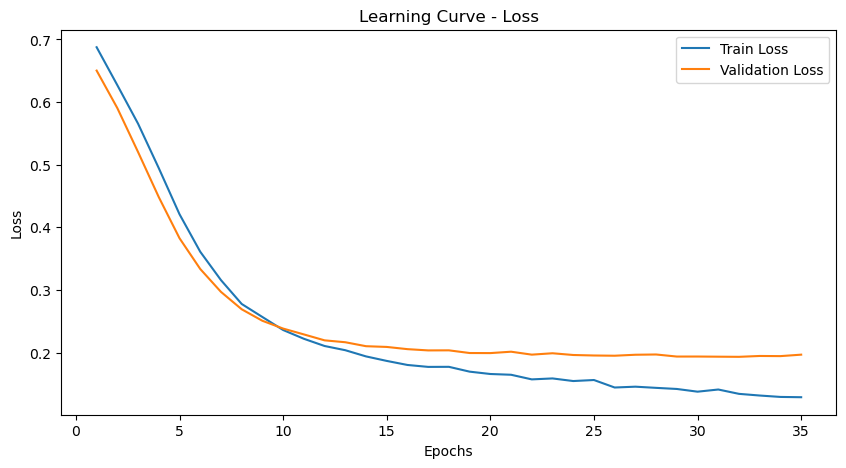

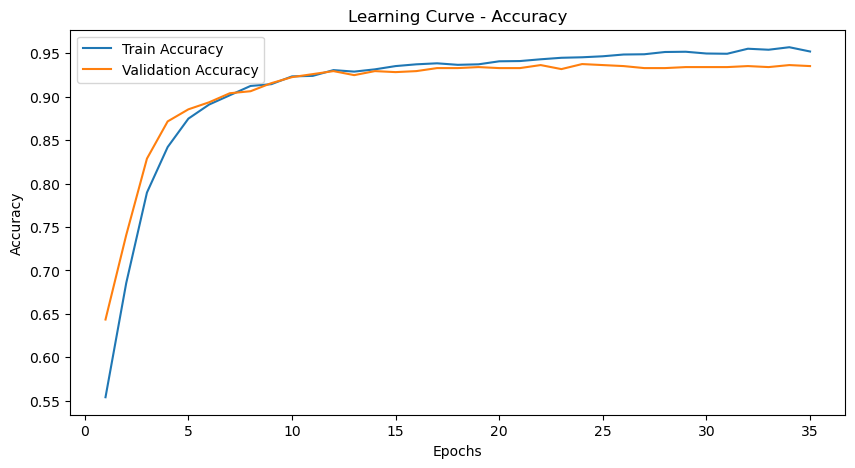

In [53]:
# Plotting learning curve for loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve - Loss')
plt.show()

# Plotting learning curve for accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve - Accuracy')
plt.show()

In [55]:
# Evaluating on Test Data
model.eval()
all_predictions = []
all_targets = []

for batch in tqdm(test_loader, desc="Evaluating on Test Data"):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    targets = batch['targets'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    predictions = torch.argmax(logits, dim=-1)
    all_predictions.extend(predictions.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

# Define target names for the classification report
target_names = ['Negative', 'Positive']

# Generate and print the classification report
print(classification_report(all_targets, all_predictions, target_names=target_names))

Evaluating on Test Data: 100%|██████████| 68/68 [01:56<00:00,  1.71s/it]

              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94       557
    Positive       0.92      0.95      0.93       523

    accuracy                           0.94      1080
   macro avg       0.94      0.94      0.94      1080
weighted avg       0.94      0.94      0.94      1080



In [57]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[516  41]
 [ 28 495]]


In [59]:
# Function to predict sentiment
def predict_sentiment(review, tokenizer, model, max_len=128):
    model.eval()
    inputs = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    prediction = torch.argmax(logits, dim=-1).cpu().numpy()[0]
    return "Positif" if prediction == 1 else "Negatif"

In [61]:
# Test the prediction function
example_reviews = [
    "upload produk hasil foto sendiri tapi kena pelanggaran",
    "tampilannya mempermudah pengguna baru"
]

for review in example_reviews:
    sentiment = predict_sentiment(review, tokenizer, model)
    print(f"Review: {review} | Sentiment: {sentiment}")

Review: upload produk hasil foto sendiri tapi kena pelanggaran | Sentiment: Negatif
Review: tampilannya mempermudah pengguna baru | Sentiment: Positif


In [46]:
# Simpan model
model_dir = "sentiment_model"
model.save_pretrained(model_dir)

# Simpan tokenizer
tokenizer_dir = "sentiment_tokenizer"
tokenizer.save_pretrained(tokenizer_dir)

('sentiment_tokenizer\\tokenizer_config.json',
 'sentiment_tokenizer\\special_tokens_map.json',
 'sentiment_tokenizer\\vocab.txt',
 'sentiment_tokenizer\\added_tokens.json')